In [1]:
import os
import json
import shutil
import random
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
from tqdm import tqdm


In [2]:
RAW_DATASET_DIR = "Data_merged"
PROCESSED_DATA_DIR = "data_Clean_merged"

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-4
SEED = 42

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
def inspect_dataset(dataset_dir):
    print("\n📊 Dataset inspection:")
    class_counts = {}
    for cls in sorted(os.listdir(dataset_dir)):
        cls_path = os.path.join(dataset_dir, cls)
        if os.path.isdir(cls_path):
            class_counts[cls] = len(os.listdir(cls_path))

    print(f"Total classes: {len(class_counts)}")
    for cls, cnt in sorted(class_counts.items(), key=lambda x: x[1]):
        print(f"{cls}: {cnt}")

    return class_counts

In [4]:
def split_dataset(raw_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    print("\n📂 Splitting dataset...")

    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    for cls in os.listdir(raw_dir):
        cls_path = os.path.join(raw_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        images = os.listdir(cls_path)

        train_imgs, temp_imgs = train_test_split(
            images, test_size=1 - train_ratio, random_state=SEED
        )
        val_imgs, test_imgs = train_test_split(
            temp_imgs, test_size=0.5, random_state=SEED
        )

        for split, split_imgs in zip(
            ["train", "val", "test"], [train_imgs, val_imgs, test_imgs]
        ):
            split_cls_dir = os.path.join(output_dir, split, cls)
            os.makedirs(split_cls_dir, exist_ok=True)

            for img in split_imgs:
                src = os.path.join(cls_path, img)
                dst = os.path.join(split_cls_dir, img)
                shutil.copy(src, dst)

    print("✅ Dataset split completed.")

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [6]:
def load_dataloaders(data_dir):
    train_ds = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
    val_ds   = datasets.ImageFolder(os.path.join(data_dir, "val"),   transform=val_test_transform)
    test_ds  = datasets.ImageFolder(os.path.join(data_dir, "test"),  transform=val_test_transform)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    return train_ds, val_ds, test_ds, train_loader, val_loader, test_loader

In [7]:
def build_model(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(DEVICE)

In [8]:
def train_model(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_val_acc = 0.0

    for epoch in range(EPOCHS):
        print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")

        # ---- TRAIN ----
        model.train()
        train_loss = 0.0

        for imgs, labels in tqdm(train_loader):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # ---- VALIDATION ----
        model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f"Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "vision_to_gardiner_best.pth")

    print("\n✅ Training finished.")
    return model

In [9]:
def evaluate_model(model, test_loader, idx_to_class):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print("\n📊 Classification Report:")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=[idx_to_class[i] for i in range(len(idx_to_class))]
    ))

    print("\n📉 Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

In [10]:
inspect_dataset(RAW_DATASET_DIR)

if not os.path.exists(PROCESSED_DATA_DIR):
    split_dataset(RAW_DATASET_DIR, PROCESSED_DATA_DIR)



📊 Dataset inspection:
Total classes: 353
a1: 500
a14: 500
a15: 500
a16: 500
a17: 500
a19: 500
a2: 500
a24: 500
a26: 500
a28: 500
a3: 500
a30: 500
a4: 500
a40: 500
a42: 500
a50: 500
a51: 500
a6: 500
a8: 500
a9: 500
aa11: 500
aa13: 500
aa2: 500
aa5: 500
b1: 500
c10: 500
c11: 500
c2: 500
d12: 500
d18: 500
d37: 500
d38: 500
d40: 500
d41: 500
d42: 500
d44: 500
d45: 500
d5: 500
d51: 500
d55: 500
d57: 500
d7: 500
e10: 500
e13: 500
e16: 500
e18: 500
e19: 500
e20: 500
e21: 500
e28: 500
e29: 500
e4: 500
e7: 500
e8: 500
f1: 500
f2: 500
f24: 500
f3: 500
f37: 500
f39: 500
f44: 500
f48: 500
f5: 500
f51: 500
g20: 500
g27: 500
g30: 500
g38: 500
g41: 500
g47: 500
g54: 500
g8: 500
g9: 500
h1: 500
h2: 500
h8: 500
i1: 500
i12: 500
i14: 500
i15: 500
i3: 500
k1: 500
k4: 500
l2: 500
l7: 500
m13: 500
m15: 500
m2: 500
m22: 500
m24: 500
m27: 500
m30: 500
m37: 500
m6: 500
n11: 500
n12: 500
n13: 500
n15: 500
n23: 500
n27: 500
n28: 500
n33: 500
n33b: 500
n38: 500
n39: 500
n40: 500
n42: 500
n58: 500
n6: 500
n7: 50

In [11]:
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader = load_dataloaders(PROCESSED_DATA_DIR)

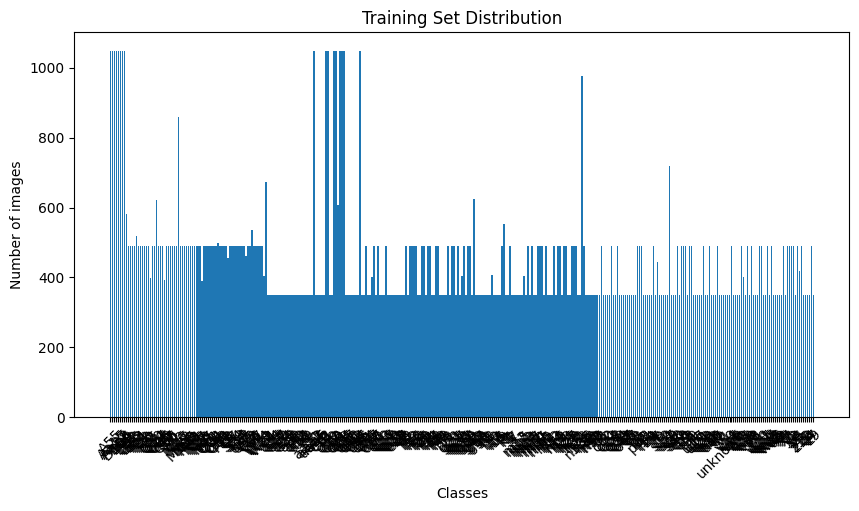

In [13]:
# Plot dataset distribution
import matplotlib.pyplot as plt
def plot_dataset_distribution(dataset, title):
    class_counts = {}
    for _, label in dataset:
        class_name = dataset.classes[label]
        if class_name not in class_counts:
            class_counts[class_name] = 0
        class_counts[class_name] += 1
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of images")
    plt.xticks(rotation=45)
    plt.show()
plot_dataset_distribution(train_ds, "Training Set Distribution")

In [49]:
class_to_idx = train_ds.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

with open("class_map.json", "w") as f:
    json.dump(idx_to_class, f, indent=2)

In [28]:
model = build_model(num_classes=len(class_to_idx))
model = train_model(model, train_loader, val_loader)


🚀 Epoch 1/5


100%|██████████| 4925/4925 [24:34<00:00,  3.34it/s]


Train Loss: 4112.6669 | Val Acc: 0.9697

🚀 Epoch 2/5


100%|██████████| 4925/4925 [19:57<00:00,  4.11it/s]


Train Loss: 457.5887 | Val Acc: 0.9844

🚀 Epoch 3/5


100%|██████████| 4925/4925 [30:38<00:00,  2.68it/s]


Train Loss: 249.8333 | Val Acc: 0.9895

🚀 Epoch 4/5


100%|██████████| 4925/4925 [22:18<00:00,  3.68it/s]


Train Loss: 186.8148 | Val Acc: 0.9895

🚀 Epoch 5/5


100%|██████████| 4925/4925 [17:54<00:00,  4.59it/s]


Train Loss: 148.4461 | Val Acc: 0.9902

✅ Training finished.


In [50]:
model.load_state_dict(torch.load("vision_to_gardiner_best.pth"))
evaluate_model(model, test_loader, idx_to_class)

C:\Users\saifk\AppData\Local\Temp\ipykernel_12872\2409135489.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("vision_to_gardiner_best.pt


📊 Classification Report:
              precision    recall  f1-score   support

         A55       1.00      1.00      1.00       226
        Aa15       0.99      0.96      0.98       226
        Aa27       1.00      1.00      1.00       226
        Aa28       1.00      1.00      1.00       226
        D156       1.00      1.00      1.00       226
         D36       0.97      0.99      0.98       226
         D39       0.99      1.00      0.99       226
          D4       0.98      0.99      0.98       226
         D52       0.99      1.00      1.00       124
         D53       1.00      1.00      1.00       106
         D56       1.00      1.00      1.00       106
         D62       1.00      1.00      1.00       106
         E23       1.00      1.00      1.00       106
         E34       1.00      0.97      0.99       112
         F21       1.00      0.99      1.00       106
         F22       1.00      1.00      1.00       106
         F23       1.00      1.00      1.00       106
 

In [51]:
from PIL import Image
import torch.nn.functional as F

def load_trained_model(model_path, class_map_path):
    with open(class_map_path, "r") as f:
        idx_to_class = json.load(f)

    num_classes = len(idx_to_class)
    model = build_model(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    return model, idx_to_class


In [52]:
inference_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [53]:

def image_to_gardiner(
    image_path,
    model,
    idx_to_class,
    top_k=3
):
    img = Image.open(image_path).convert("RGB")

# i need to show the image 
    import matplotlib.pyplot as plt
    img = inference_transform(img)
    plt.imshow(img.permute(1, 2, 0))

    
    img = img.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        outputs = model(img)
        probs = F.softmax(outputs, dim=1)[0]

    top_probs, top_idxs = torch.topk(probs, top_k)

    results = []
    for prob, idx in zip(top_probs, top_idxs):
        results.append({
            "gardiner_code": idx_to_class[str(idx.item())],
            "confidence": round(prob.item(), 4)
        })

    return results


C:\Users\saifk\AppData\Local\Temp\ipykernel_12872\3294809450.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=D


🔍 Prediction Results:
G5 → confidence: 0.3775
e20 → confidence: 0.3616
G1 → confidence: 0.2355
s3 → confidence: 0.0085
G36 → confidence: 0.0059
g4 → confidence: 0.0039
w9 → confidence: 0.0018
d45 → confidence: 0.0009
y4 → confidence: 0.0005
g43 → confidence: 0.0004


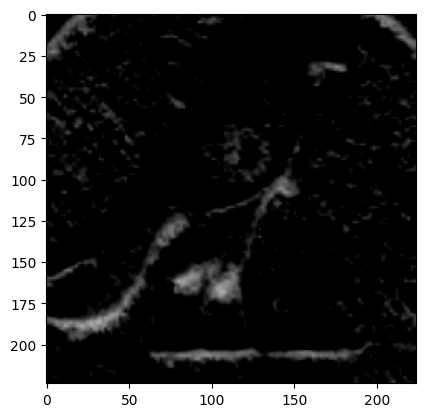

In [57]:
if __name__ == "__main__":
    model, idx_to_class = load_trained_model(
        model_path="vision_to_gardiner_best.pth",
        class_map_path="class_map.json"
    )

    test_image = "WhatsApp Image 2025-12-20 at 7.42.54 PM.jpeg" 
    predictions = image_to_gardiner(
        test_image,
        model,
        idx_to_class,
        top_k=10
    )

    print("\n🔍 Prediction Results:")
    for p in predictions:
        print(f"{p['gardiner_code']} → confidence: {p['confidence']}")
